In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar



C:\Users\Bruker\AppData\Local\Temp\ipykernel_16596\381719416.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('leknes.tif')


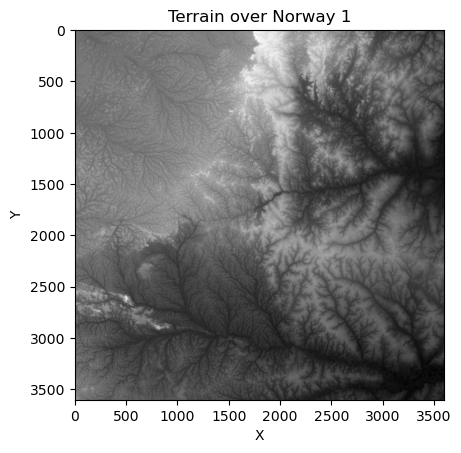

In [15]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('leknes.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def real_terrain_OLS(data, x, y, lower_poly, upper_poly, noise, sigma, scaling):
  test_mse = []
  test_r2 = []
  train_mse = []
  train_r2 = []
  betas = []

  poly_order_range = range(1,6)

  x = np.linspace(0, 1, x)
  y = np.linspace(0, 1, y)

  x, y = np.meshgrid(x,y)

  z = data
  z = np.ravel(z)
  #SCALE
  z = (z-z.mean()/z.std())

  count = 0
  for order in poly_order_range:
    poly = PolynomialFeatures(order)
    X = poly.fit_transform(np.c_[x.ravel(), y.ravel()])

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    if scaling == 1:
      X_train = X_train - np.mean(X_train, axis=0)
      X_test = X_test - np.mean(X_test, axis=0)
      z_train = z_train - np.mean(z_train, axis=0)
      z_test = z_test - np.mean(z_test, axis=0)
    
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    test_mse.append(mean_squared_error(z_test, z_predict))
    train_mse.append(mean_squared_error(z_train, z_tilde))
    test_r2.append(r2_score(z_test, z_predict))
    train_r2.append(r2_score(z_train, z_tilde))
    betas.append(beta)
    count += 1
    print(count)

  return test_mse, train_mse, test_r2, train_r2, betas


terrain1 = terrain1[::10, ::10]
x = terrain1.shape[0]
y = terrain1.shape[1]

lower_poly = 1
upper_poly = 5
noise = 0
sigma = 0
scaling = 0
test_mse1, train_mse1, test_r2_1, train_r2_1, betas = real_terrain_OLS(terrain1, x, y, lower_poly, upper_poly, noise, sigma, scaling)


1
2
3
4
5


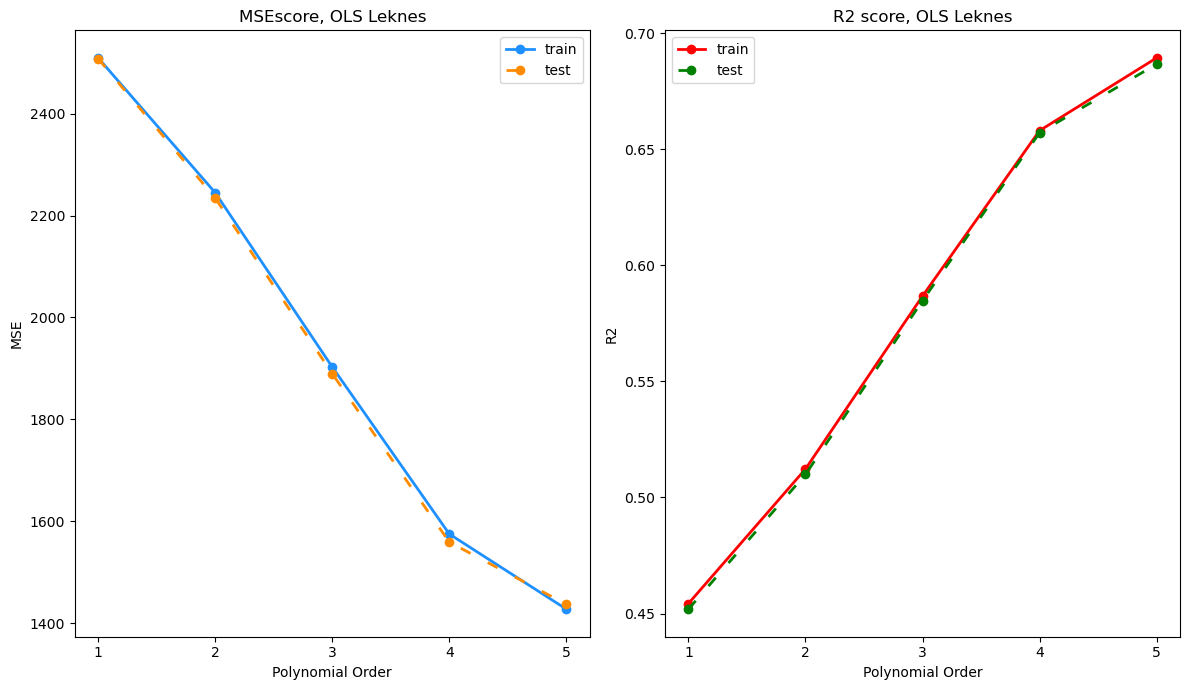

In [35]:
from matplotlib.ticker import MaxNLocator

fig,ax = plt.subplots(1,2, figsize=(12,7))
poly_order_range = range(lower_poly, upper_poly+1)
lw=2
dashl = 4
dashs = 7
ax[0].plot(poly_order_range, train_mse1, '-o', lw=lw, color='dodgerblue', label='train')
ax[0].plot(poly_order_range, test_mse1, '--o', lw=lw, dashes=(dashl, dashs), color='darkorange', label='test')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel('Polynomial Order')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSEscore, OLS Leknes')
ax[0].legend()

ax[1].plot(poly_order_range, train_r2_1, '-o',lw=lw, color='red', label='train')
ax[1].plot(poly_order_range, test_r2_1, '--o',lw=lw, dashes=(dashl, dashs), color='green', label='test')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel('Polynomial Order')
ax[1].set_ylabel('R2')
ax[1].set_title('R2 score, OLS Leknes')
ax[1].legend()


plt.tight_layout()

In [40]:
def ridge_real_data(data, x, y, lower, upper, noise, sigma, nlambdas, scaling):
  np.random.seed(123)

  test_mse = []
  train_mse = []

  poly_range = range(lower, upper+1)

  x = np.linspace(0,1,x)
  y = np.linspace(0,1,y)

  x_gr, y_gr = np.meshgrid(x,y)

  z = data

  z = (z-z.mean())/z.std()

  count = 0

  for order in poly_range:
    poly = PolynomialFeatures(order)
    X = poly.fit_transform(np.c_[x.ravel(), y.ravel()])

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

    if scaling == 1:
      X_train = X_train - np.mean(X_train, axis=0)
      X_test = X_test - np.mean(X_test, axis=0)
      z_train = z_train - np.mean(z_train, axis=0)
      z_test = z_test - np.mean(z_test, axis=0)

    I = np.eye(X_train.shape[1], X_train.shape[1])

    test_mse_temp = np.zeros(nlambdas)
    train_mse_temp = np.zeros(nlambdas)

    lambdas = np.logspace(-4, 1, nlambdas)

    for i in range(nlambdas):
      lmb = lambdas[i]

      ridgeBeta = np.linalg.pinv(X_train.T @ X_train + lmb*I) @ X_train.T @ z_train
      zThildeRidge = X_train @ ridgeBeta
      zPredRidge = X_test @ ridgeBeta

      test_mse[i] = mean_squared_error(z_test, zPredRidge)
      train_mse[i] = mean_squared_error(z_train, zThildeRidge)
    
    train_mse.append(train_mse_temp)
    test_mse.append(test_mse_temp)
    count+=1
    print(count)
  train_MSEs = np.array(train_MSEs)
  test_MSEs = np.array(test_MSEs)

  return train_mse, test_mse



npointsx = terrain1.shape[0]
npointsy = terrain1.shape[1]
lower_poly = 1
upper_poly = 5
noise = 0
sigma = 0
scaling = 1
nlambdas = 20
lambdas = np.logspace(-4, 1, nlambdas)
train_MSEs, test_MSEs = ridge_real_data(terrain1, npointsx, npointsy, lower_poly, upper_poly, noise, sigma, nlambdas, scaling)


IndexError: list assignment index out of range